              Price    Open    High     Low   Vol. Change %
Date                                                       
2018-01-02  41700.0  40,942  42,003  40,638  3.57M    1.29%
2018-01-03  41624.0  42,079  42,230  41,321  2.35M   -0.18%
2018-01-04  42003.0  41,396  42,003  41,169  2.54M    0.91%
2018-01-05  40942.0  41,776  41,776  40,866  2.61M   -2.53%
2018-01-08  42003.0  40,942  42,079  40,183  2.64M    2.59%
              Price    Open    High     Low   Vol. Change %      SMA
Date                                                                
2018-01-02  41700.0  40,942  42,003  40,638  3.57M    1.29%      NaN
2018-01-03  41624.0  42,079  42,230  41,321  2.35M   -0.18%      NaN
2018-01-04  42003.0  41,396  42,003  41,169  2.54M    0.91%      NaN
2018-01-05  40942.0  41,776  41,776  40,866  2.61M   -2.53%      NaN
2018-01-08  42003.0  40,942  42,079  40,183  2.64M    2.59%  41654.4
2018-01-09  44353.0  42,458  44,353  41,321  3.64M    5.59%  42185.0
2018-01-10  43974.0  44,202 

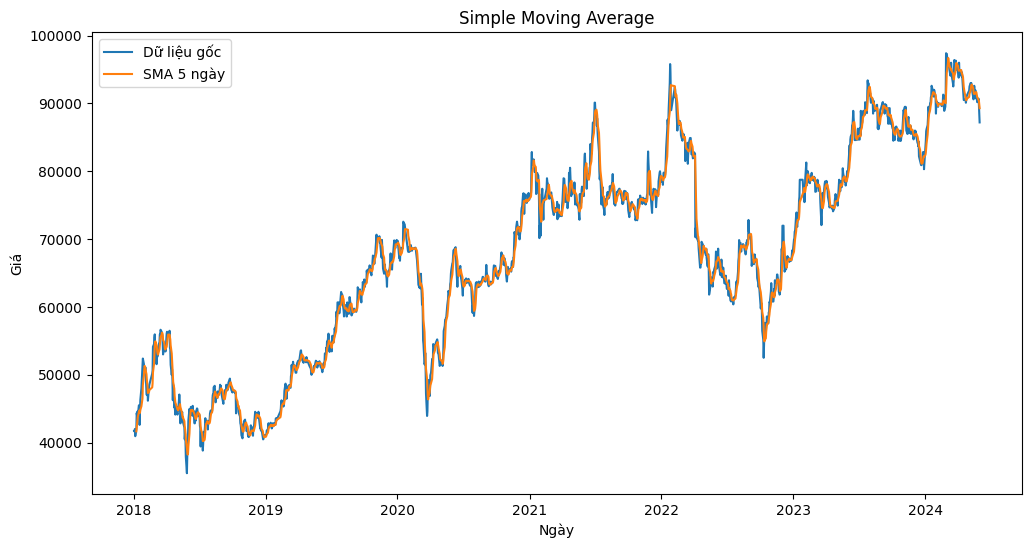

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Đọc dữ liệu từ file CSV vào DataFrame
df = pd.read_csv('../Dataset/VCB Historical Data.csv')

# Chuyển đổi cột 'Date' sang định dạng datetime nếu chưa phải
df['Date'] = pd.to_datetime(df['Date'])

# Convert cột 'Price' sang dạng số nếu cần thiết (loại bỏ dấu phẩy và chuyển sang float)
df['Price'] = df['Price'].str.replace(',', '').astype(float)

# Sắp xếp dữ liệu theo thời gian từ cũ đến mới
df.sort_values(by='Date', inplace=True)

# Đặt cột 'Date' làm index của DataFrame
df.set_index('Date', inplace=True)

# In ra một số dòng đầu của DataFrame để kiểm tra
print(df.head())

# Thiết lập cửa sổ (window size) cho SMA
window_size = 5  # ví dụ: SMA 10 ngày

# Tính toán Simple Moving Average (SMA)
df['SMA'] = df['Price'].rolling(window=window_size).mean()

# In ra DataFrame đã có cột SMA để kiểm tra
print(df.head(10))  # in 10 dòng đầu tiên để xem kết quả

# Vẽ biểu đồ
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], label='Dữ liệu gốc')  # Sử dụng df.index làm trục x
plt.plot(df.index, df['SMA'], label=f'SMA {window_size} ngày')
plt.legend(loc='best')
plt.title('Simple Moving Average')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.show()


In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def XGBoost(dataset_path, test_size=0.2, window_size=5,name=''):
    # Load data into DataFrame df
    df = pd.read_csv(dataset_path)

    # Convert Date column to datetime and set it as index
    df['Date'] = pd.to_datetime(df['Date'])

    # Convert other columns to numeric if necessary
    df['Price'] = df['Price'].str.replace(',', '').astype(float)

    # Sort data by time from past to present
    df.sort_values(by='Date', inplace=True)

    # Calculate Simple Moving Average (SMA)
    df['SMA'] = df['Price'].rolling(window=window_size).mean()

    # Create time features from Date column
    df['day'] = df['Date'].dt.day
    df['month'] = df['Date'].dt.month
    df['year'] = df['Date'].dt.year
    df['day_of_week'] = df['Date'].dt.dayofweek

    # Create lag features to capture patterns in the past
    df['price_lag1'] = df['SMA'].shift(1)
    df['price_lag2'] = df['SMA'].shift(2)
    df['price_lag3'] = df['SMA'].shift(3)

    # Remove rows with NaN values due to lag feature creation
    df.dropna(inplace=True)

    # Select features and label
    features = ['day', 'month', 'year', 'day_of_week', 'price_lag1', 'price_lag2', 'price_lag3']
    X = df[features]
    y = df['SMA']  # Use the smoothed SMA values as the target

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    # Convert data to XGBoost DMatrix format
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Define parameters for XGBoost model
    params = {
        'booster': 'gbtree',
        'objective': 'reg:squarederror',  # Regression objective
        'eta': 0.1,
        'max_depth': 5,
        'eval_metric': 'rmse'
    }

    # Number of training rounds
    num_round = 100

    # Train the model
    bst = xgb.train(params, dtrain, num_round)

    # Make predictions on the test set
    y_pred = bst.predict(dtest)

    # Evaluate the model
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'RMSE: {rmse:.2f}')

    mae = mean_absolute_error(y_test, y_pred)
    print(f'MAE: {mae:.2f}')

    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
    print(f'MAPE: {mape:.2f}%')

    # Plotting
    plt.figure(figsize=(14, 7))

    # Plot the actual prices for training set
    plt.plot(df['Date'].iloc[:len(y_train)], df['Price'].iloc[:len(y_train)], label='Train Data', color='blue')

    # Plot the actual prices for test set
    plt.plot(df['Date'].iloc[len(y_train):len(y_train)+len(y_test)], df['Price'].iloc[len(y_train):len(y_train)+len(y_test)], label='Test Data', color='green')

    # Plot the predictions for test set
    plt.plot(df['Date'].iloc[len(y_train):len(y_train)+len(y_test)], y_pred, label='Predicted on Test', color='red')

    # Additional predictions for the future
    last_test_date = df['Date'].iloc[len(y_train) + len(y_test) - 1]
    future_dates = pd.date_range(start=last_test_date + pd.Timedelta(days=1), periods=90, freq='B')

    # Initialize lag values with the last known values from the SMA data
    initial_lag_prices = df['Price'].iloc[-(window_size-1):].tolist()
    initial_lag_smas = df['SMA'].iloc[-(window_size-1):].tolist()

    future_pred = []

    for future_date in future_dates:
        # Calculate SMA for future_date
        future_sma = np.mean(initial_lag_prices)

        # Create a DataFrame for the current day
        future_df = pd.DataFrame({'Date': [future_date]})
        future_df['day'] = future_df['Date'].dt.day
        future_df['month'] = future_df['Date'].dt.month
        future_df['year'] = future_df['Date'].dt.year
        future_df['day_of_week'] = future_df['Date'].dt.dayofweek
        future_df['price_lag1'] = initial_lag_smas[-1]
        future_df['price_lag2'] = initial_lag_smas[-2]
        future_df['price_lag3'] = initial_lag_smas[-3]

        # Convert to DMatrix format
        d_future = xgb.DMatrix(future_df[features])

        # Predict the SMA for the current day
        future_sma = bst.predict(d_future)

        # Append the prediction to the list
        future_pred.append(future_sma[0])

        # Update the lag values
        initial_lag_smas.append(future_sma[0])
        initial_lag_smas.pop(0)

        # Update the lag prices with the predicted SMA converted to a price estimate
        predicted_price = future_sma[0] * window_size - sum(initial_lag_prices[:-1])
        initial_lag_prices.append(predicted_price)
        initial_lag_prices.pop(0)

    # Plot future predictions
    future_pred = np.array(future_pred)

    # Divide the next 90 days into 3 periods of 30 days each and plot with different colors
    future_len = len(future_dates)
    segment_len = future_len // 3
    for i in range(3):
        start_idx = i * segment_len
        end_idx = (i + 1) * segment_len if i < 2 else future_len
        plt.plot(future_dates[start_idx:end_idx], future_pred[start_idx:end_idx], color=f'C{i+2}', label=f'Predicted Day {(i+1)*30}')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(f'{name} Stock Price with XGBoost ({1-test_size})')
    plt.legend()
    plt.show()

# Example usage


In [23]:
dataset_path_VCB = '../Dataset/VCB Historical Data.csv'
dataset_path_MBB = '../Dataset/MBB Historical Data.csv'
dataset_path_BIDV = '../Dataset/BID Historical Data.csv'


VCB XGBOOST 0.7

RMSE: 1223.78
MAE: 793.18
MAPE: 0.96%


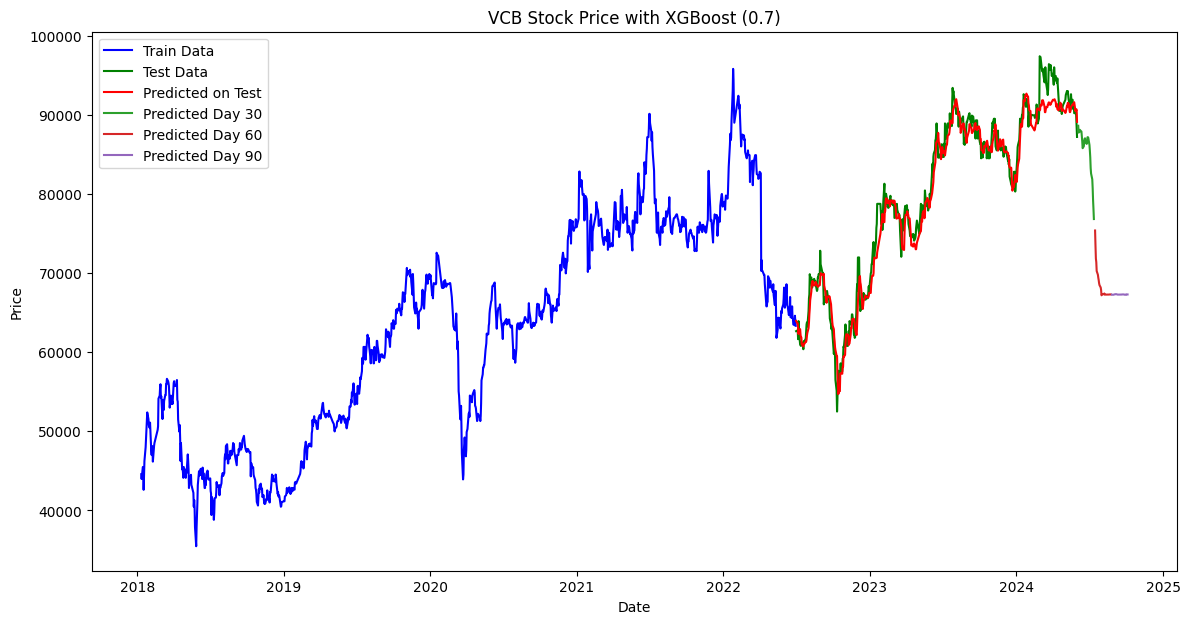

In [24]:
XGBoost(dataset_path_VCB,0.3,5,'VCB')

VCB XGBOOST 0.8

RMSE: 1481.31
MAE: 894.92
MAPE: 0.99%


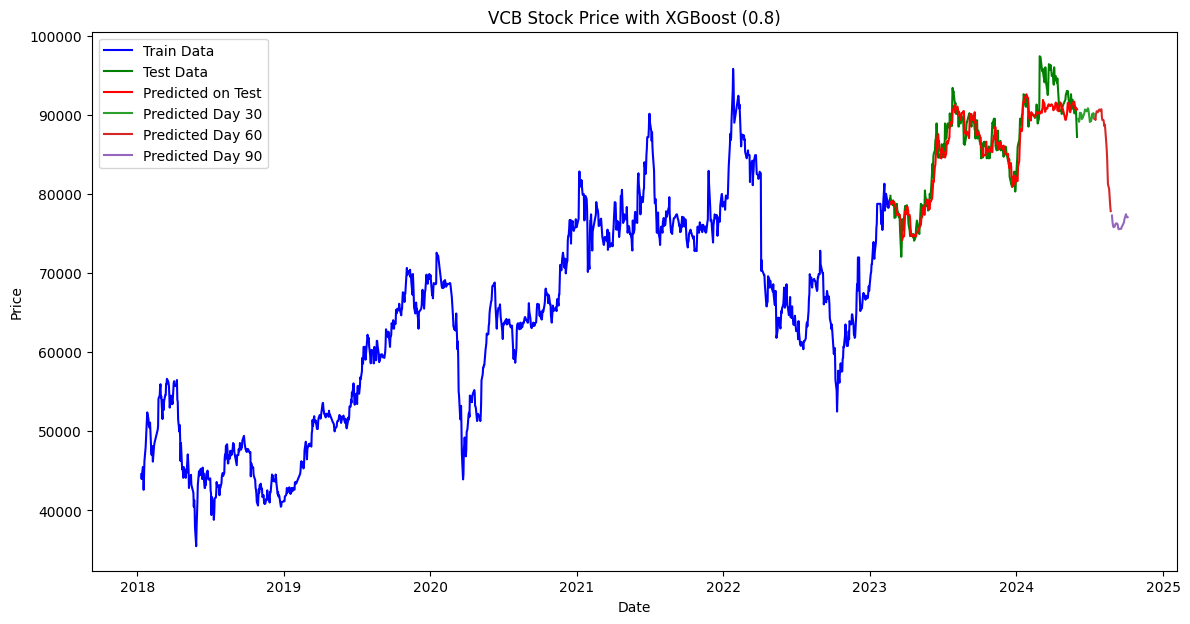

In [25]:
XGBoost(dataset_path_VCB,0.2,5,'VCB')

VCB XGBOOST 0.9

RMSE: 1571.18
MAE: 988.49
MAPE: 1.06%


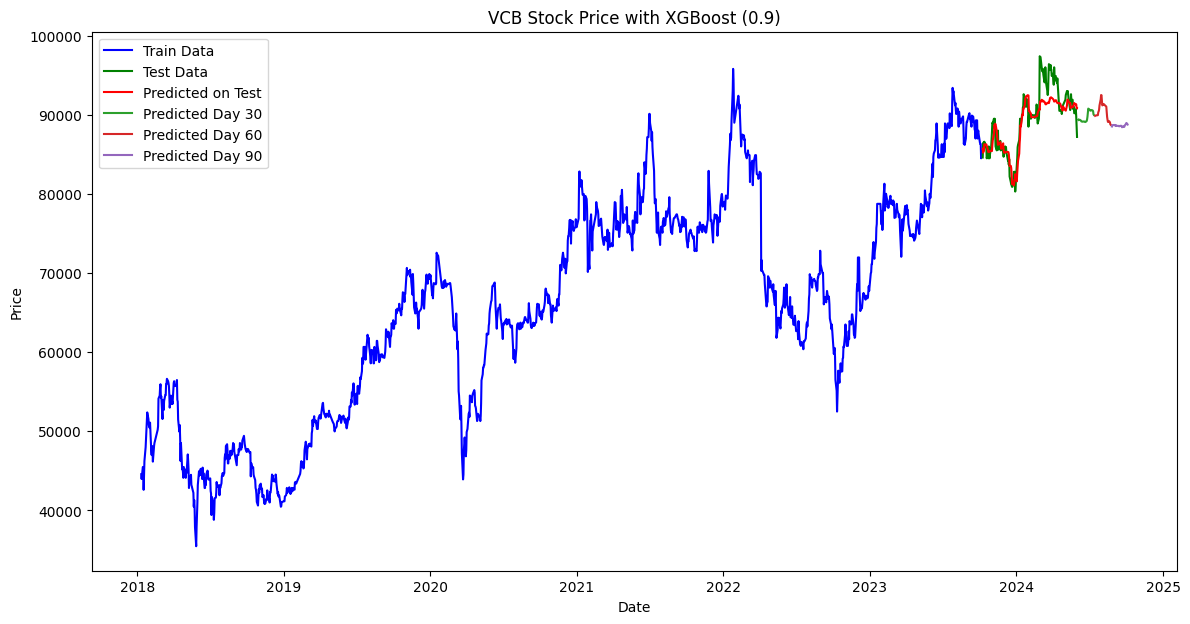

In [26]:
XGBoost(dataset_path_VCB,0.1,5,'VCB')

MBB XGBOOST 0.7

RMSE: 285.05
MAE: 217.39
MAPE: 1.20%


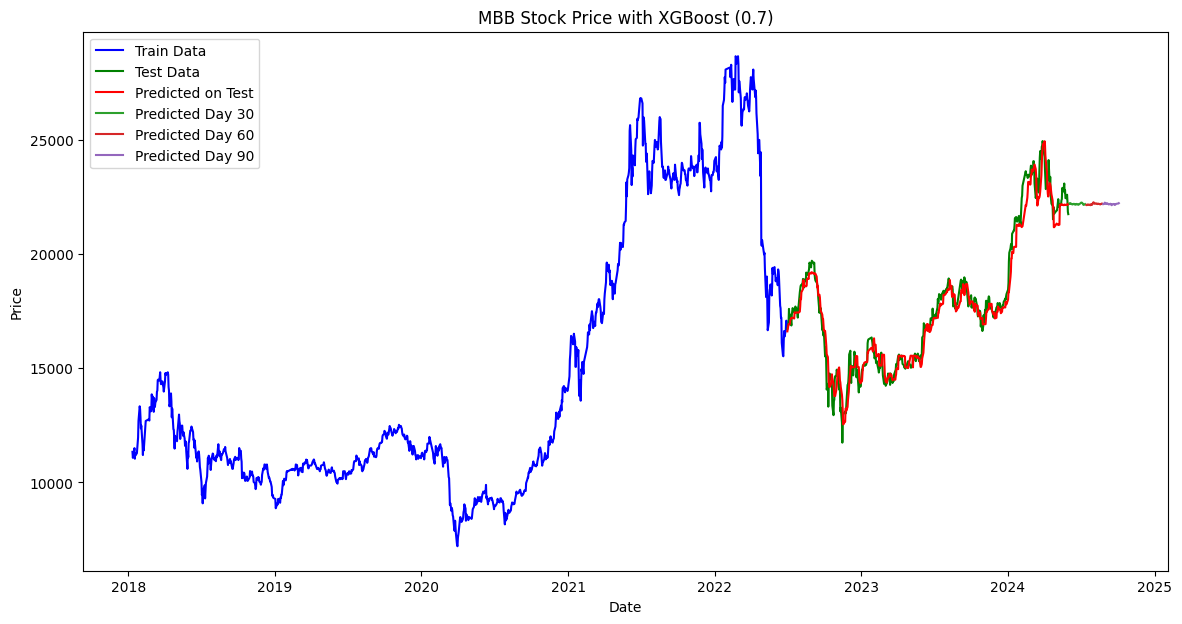

In [37]:
XGBoost(dataset_path_MBB,0.3,5,'MBB')

MBB XGBOOST 0.8

RMSE: 304.36
MAE: 196.86
MAPE: 0.98%


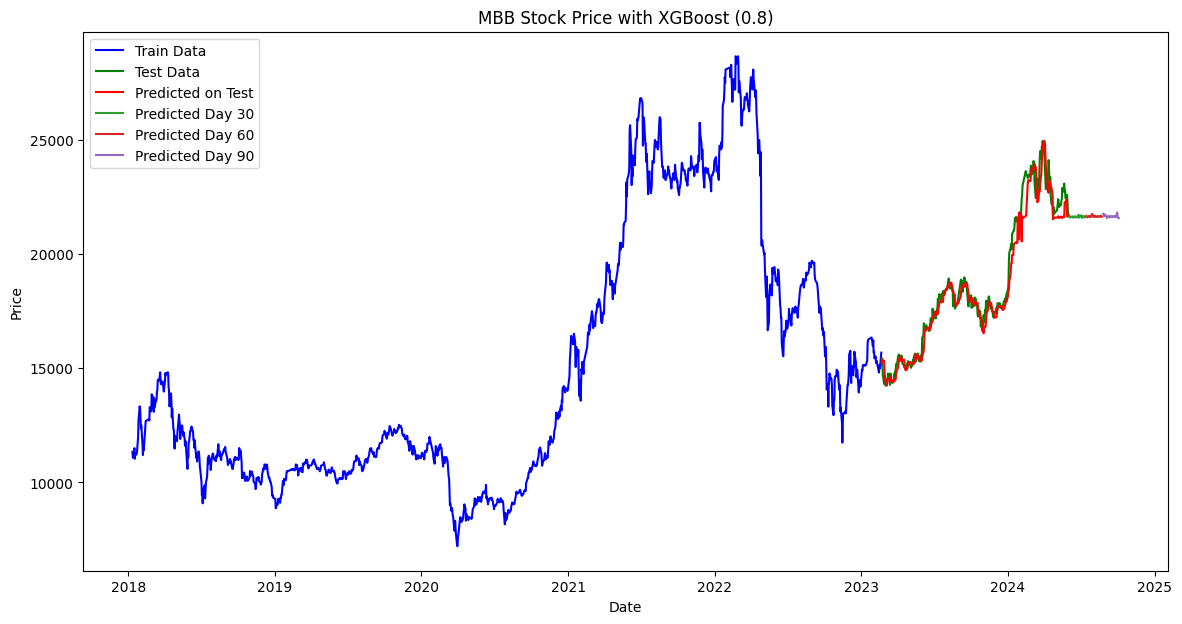

In [28]:
XGBoost(dataset_path_MBB,0.2,5,'MBB')

MBB XGBOOST 0.9

RMSE: 360.88
MAE: 260.76
MAPE: 1.21%


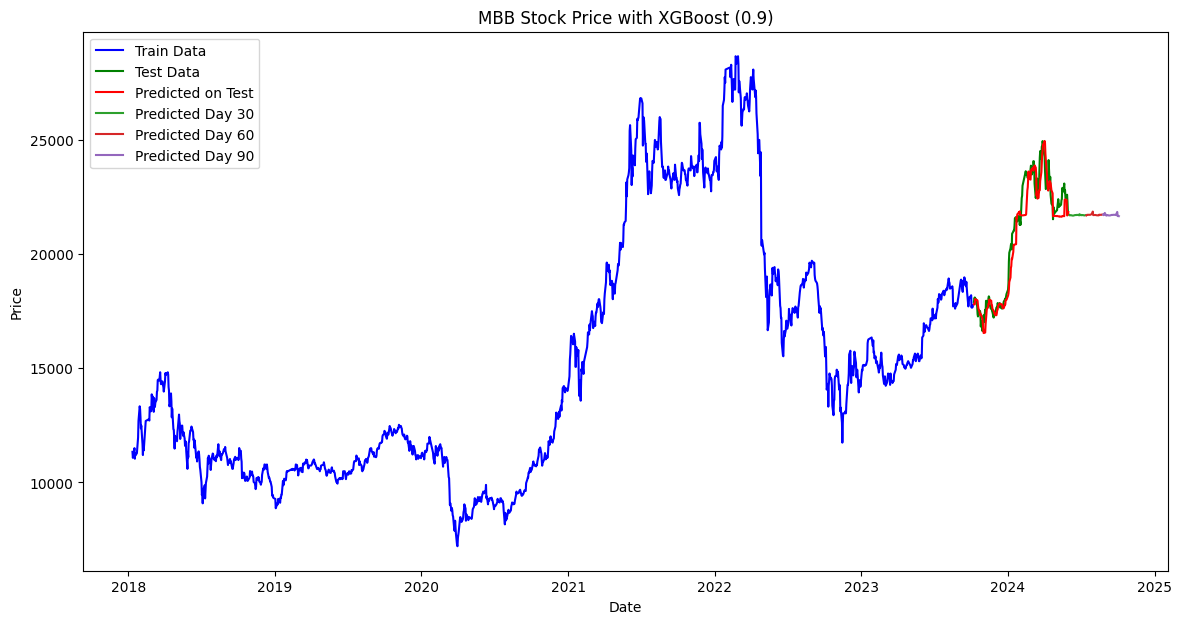

In [29]:
XGBoost(dataset_path_MBB,0.1,5,'MBB')

BIDV XGBOOST 0.7

RMSE: 1531.03
MAE: 782.56
MAPE: 1.69%


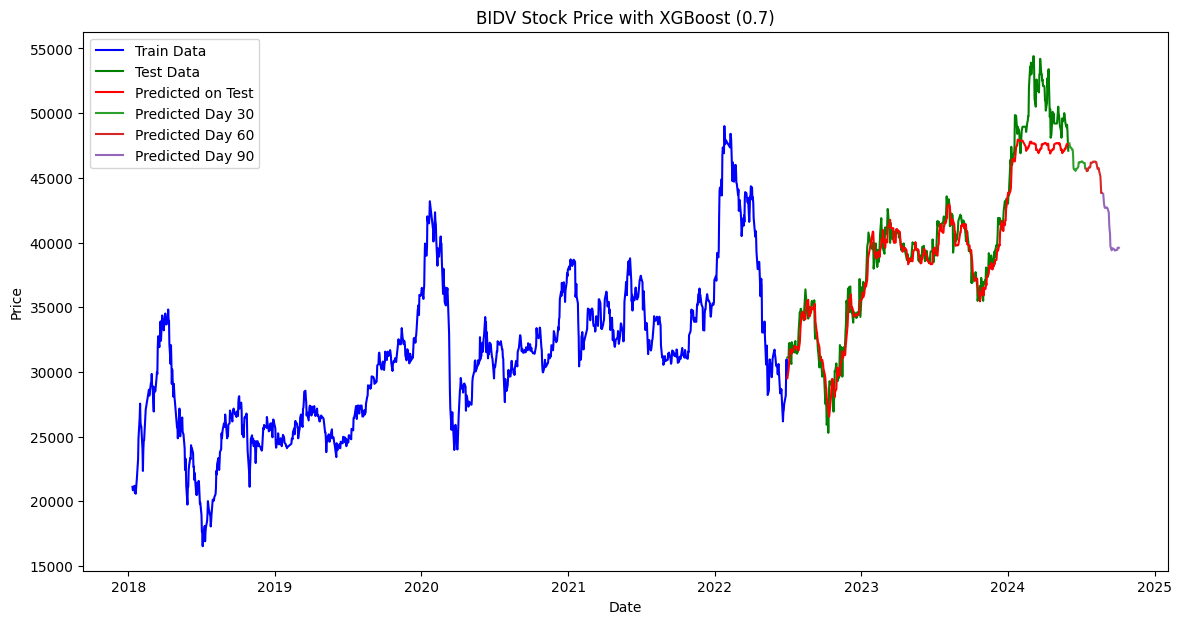

In [30]:
XGBoost(dataset_path_BIDV,0.3,5,'BIDV')

BIDV XGBOOST 0.8

RMSE: 1835.20
MAE: 1056.32
MAPE: 2.19%


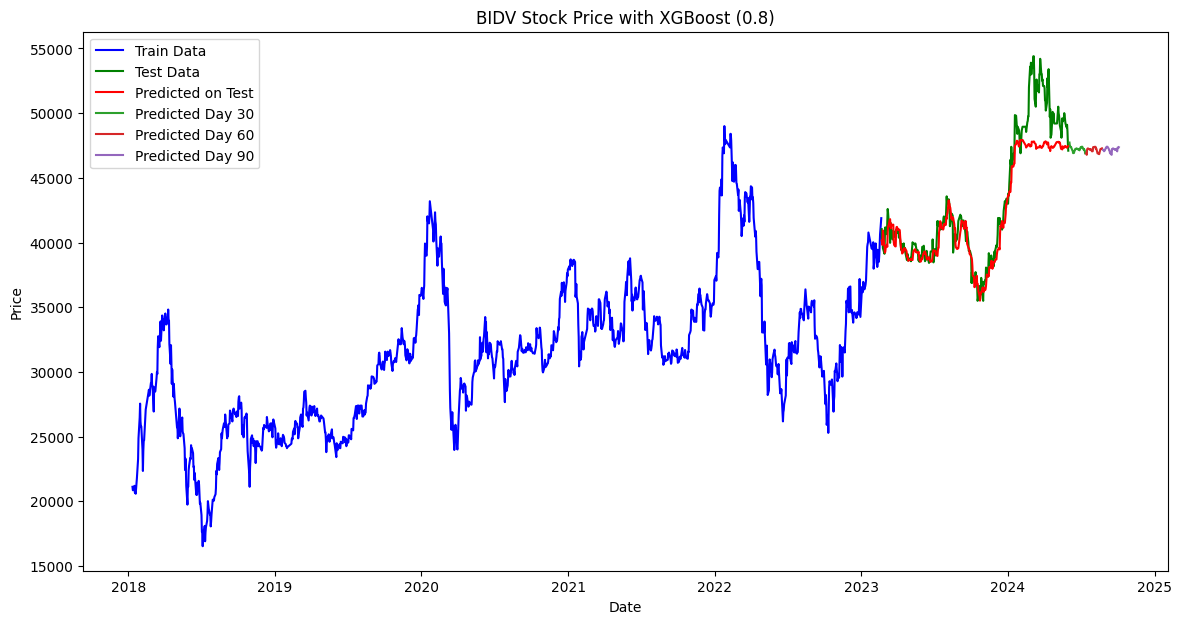

In [31]:
XGBoost(dataset_path_BIDV,0.2,5,'BIDV')

BIDV XGBOOST 0.9

RMSE: 2631.97
MAE: 1757.30
MAPE: 3.47%


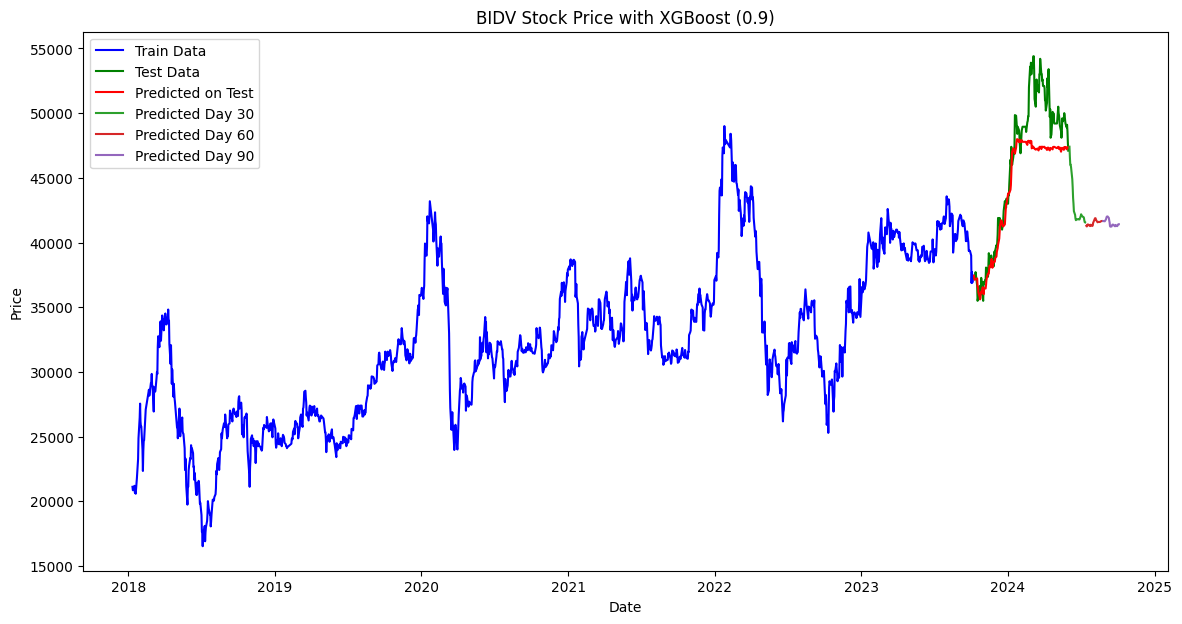

In [32]:
XGBoost(dataset_path_BIDV,0.1,5,'BIDV')